In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
import tensorflow as tf
from tensorflow import keras
from hyperopt import Trials, STATUS_OK, tpe
from hyperas.distributions import choice, uniform

2024-09-21 14:22:17.272071: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-21 14:22:17.323999: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-21 14:22:17.499565: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-21 14:22:17.499809: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-21 14:22:17.521347: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [3]:
input_dict = {'A': 0, 'C': 1, 'D': 2, 'E': 3, 'END': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10, 'M': 11, 'N': 12,
 'P': 13, 'Q': 14, 'R': 15, 'S': 16, 'T': 17, 'V': 18, 'W': 19, 'Y': 20}

placeholder_index = 4

In [3]:
def create_model(x_train, y_train, x_val, y_val, x_test, y_test):
    model = keras.models.Sequential([
        keras.layers.Input(shape=(x_train.shape[1],)),
        keras.layers.Embedding(input_dim=21, input_length=10, output_dim=50),

        keras.layers.LSTM(128, return_sequences=True, input_shape=(10,21)),
        keras.layers.Dropout({{uniform(0, 0.8)}}),

        keras.layers.LSTM(128, return_sequences=False),
        keras.layers.Dropout({{uniform(0, 0.8)}}),

        keras.layers.Dense(64),
        keras.layers.LeakyReLU(alpha={{uniform(0, 0.8)}}),

        keras.layers.Dropout({{uniform(0, 0.8)}}),
        keras.layers.Dense(1)
    ])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate={{choice([0.001, 0.005, 0.01, 0.05, 0.1])}}), loss='mean_squared_error', metrics=['mse'])

    result = model.fit(x_train, y_train, validation_split=0.3, epochs=200, batch_size={{choice([32, 64, 128, 5000])}}, verbose=2)

    mse = np.amax(result.history['val_mse']) 
    print('Best validation acc of epoch:', mse)
    return {'loss': -mse, 'status': STATUS_OK, 'model': model}

def data():
    x_train = pd.read_table('Data/20210524_A1101_xtrain.txt', sep=' ', header=None)
    y_train = pd.read_table('Data/20210524_A1101_ytrain.txt', sep=' ', header=None)
    x_val = pd.read_table('Data/20210524_A1101_xval.txt', sep=' ', header=None)
    y_val = pd.read_table('Data/20210524_A1101_yval.txt', sep=' ', header=None)
    x_test = pd.read_table('Data/20210524_A1101_xtest.txt', sep=' ', header=None)
    y_test = pd.read_table('Data/20210524_A1101_ytest.txt', sep=' ', header=None)
    return x_train, y_train, x_val, y_val, x_test, y_test
    

In [4]:
x_train = pd.read_table('Data/20210524_A1101_xtrain.txt', sep=' ', header=None)
y_train = pd.read_table('Data/20210524_A1101_ytrain.txt', sep=' ', header=None)
x_val = pd.read_table('Data/20210524_A1101_xval.txt', sep=' ', header=None)
y_val = pd.read_table('Data/20210524_A1101_yval.txt', sep=' ', header=None)
x_test = pd.read_table('Data/20210524_A1101_xtest.txt', sep=' ', header=None)
y_test = pd.read_table('Data/20210524_A1101_ytest.txt', sep=' ', header=None)

In [4]:
import keras_tuner as kt

class A1101Tuner(kt.HyperModel):
    def build(self, hp):
        model = keras.models.Sequential([
            keras.layers.Input(shape=(x_train.shape[1],)),
            keras.layers.Embedding(input_dim=21, input_length=10, output_dim=50),

            keras.layers.LSTM(128, return_sequences=True, input_shape=(10,21)),
            keras.layers.Dropout(hp.Float('dropout_1', 0, 0.8, step=0.00005)),

            keras.layers.LSTM(128, return_sequences=False),
            keras.layers.Dropout(hp.Float('dropout_2', 0, 0.8, step=0.00005)),

            keras.layers.Dense(64),
            keras.layers.LeakyReLU(alpha=hp.Float('alpha_leaky', 0, 0.8, step=0.00005)),

            keras.layers.Dropout(hp.Float('dropout_3', 0, 0.8, step=0.00005)),
            keras.layers.Dense(1)
        ])

        model.compile(
            optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', [0.001, 0.005, 0.01, 0.05, 0.1])),
            loss='mean_squared_error',
            metrics=['mse']
        )

        return model
    
    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            batch_size=hp.Choice('batch_size', [32, 64, 128, 5000]),
            **kwargs
        )


In [6]:
tuner = kt.Hyperband(
    A1101Tuner(),
    objective='val_mse',
    max_epochs=100,
    factor=3,
    directory='tuner',
    project_name='A1101_tuner'
)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [7]:
tuner.search(x_train, y_train, epochs=1000, validation_split=0.2, validation_data = (x_val, y_val), callbacks=[stop_early])

Trial 254 Complete [00h 01m 44s]
val_mse: 0.03138042613863945

Best val_mse So Far: 0.024217216297984123
Total elapsed time: 00h 57m 13s


In [8]:
model = tuner.hypermodel.build(tuner.get_best_hyperparameters()[0])

In [9]:
history = model.fit(x_train, y_train, epochs=1000, validation_data=(x_val, y_val))

Epoch 1/1000
142/142 [==============================] - 4s 20ms/step - loss: 0.0644 - mse: 0.0644 - val_loss: 0.0425 - val_mse: 0.0425
Epoch 2/1000
142/142 [==============================] - 2s 16ms/step - loss: 0.0452 - mse: 0.0452 - val_loss: 0.0421 - val_mse: 0.0421
Epoch 3/1000
142/142 [==============================] - 2s 16ms/step - loss: 0.0402 - mse: 0.0402 - val_loss: 0.0466 - val_mse: 0.0466
Epoch 4/1000
142/142 [==============================] - 2s 16ms/step - loss: 0.0390 - mse: 0.0390 - val_loss: 0.0321 - val_mse: 0.0321
Epoch 5/1000
142/142 [==============================] - 2s 16ms/step - loss: 0.0351 - mse: 0.0351 - val_loss: 0.0312 - val_mse: 0.0312
Epoch 6/1000
142/142 [==============================] - 2s 16ms/step - loss: 0.0322 - mse: 0.0322 - val_loss: 0.0302 - val_mse: 0.0302
Epoch 7/1000
142/142 [==============================] - 2s 16ms/step - loss: 0.0298 - mse: 0.0298 - val_loss: 0.0380 - val_mse: 0.0380
Epoch 8/1000
142/142 [==============================] -

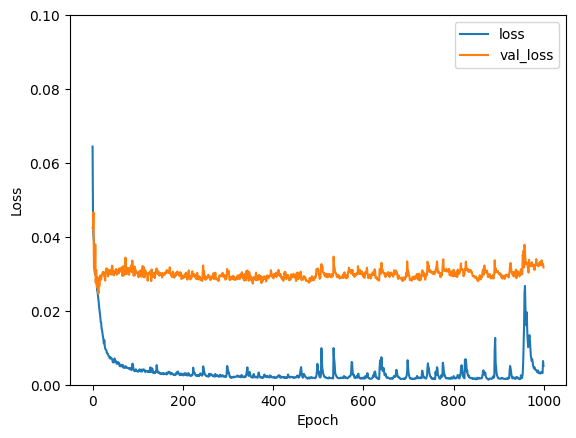

In [32]:
plt.plot(range(1000) ,history.history['loss'], label='loss')
plt.plot(range(1000), history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 0.1])
plt.legend(loc='best')
plt.show()

In [ ]:
val_loss_per_epoch = history.history['val_loss']
best_epoch = val_loss_per_epoch.index(min(val_loss_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

In [29]:
tuner.get_best_hyperparameters()[0].values

{'dropout_1': 0.67445,
 'dropout_2': 0.22710000000000002,
 'alpha_leaky': 0.22465000000000002,
 'dropout_3': 0.2199,
 'learning_rate': 0.005,
 'batch_size': 32,
 'tuner/epochs': 34,
 'tuner/initial_epoch': 12,
 'tuner/bracket': 3,
 'tuner/round': 2,
 'tuner/trial_id': '0195'}

In [ ]:
model = tuner.hypermodel.build(tuner.get_best_hyperparameters()[0])
model.fit(x_train, y_train, epochs=best_epoch, validation_data=(x_val, y_val))

In [36]:
eval_result = model.evaluate(x_test, y_test)
print("[test loss, test mse]:", eval_result)

20/20 [==============================] - 0s 7ms/step - loss: 0.0259 - mse: 0.0259
[test loss, test mse]: [0.025851581245660782, 0.025851581245660782]


In [7]:
y_pred = model.predict(x_test)
y_pred = pd.DataFrame(y_pred, index=x_test.index)
new_y_test = pd.DataFrame(y_test, index=x_test.index)

20/20 [==============================] - 1s 10ms/step


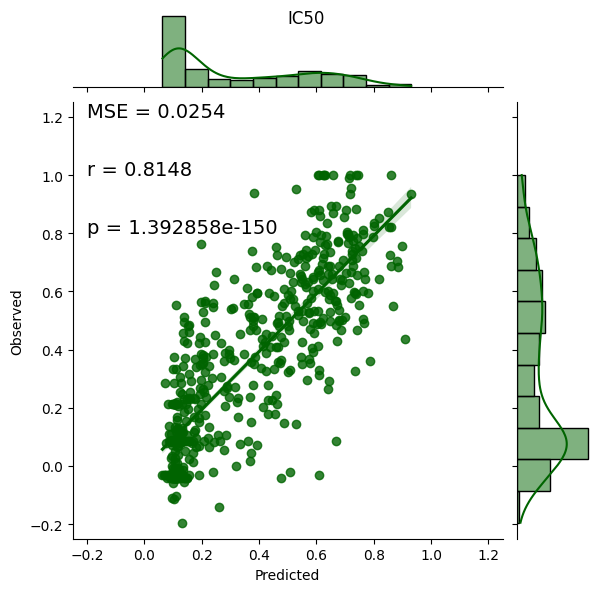

In [13]:
from scipy.stats import spearmanr
from sklearn.metrics import mean_squared_error

jp = sns.jointplot(x=y_pred.iloc[:, 0], y=new_y_test.iloc[:, 0], kind='reg', color='#006400')
jp.fig.suptitle('IC50')
jp.ax_joint.set_xlabel('Predicted')
jp.ax_joint.set_ylabel('Observed')
jp.ax_joint.set_xlim(-0.25, 1.25)
jp.ax_joint.set_ylim(-0.25, 1.25)
prCor, pCor = spearmanr(y_pred, new_y_test)
mse = round(mean_squared_error(y_pred, new_y_test),4)
jp.ax_joint.text(-.2,1.2,"MSE = " + str(mse), fontsize=14)
jp.ax_joint.text(-.2,1,"r = " + str(round(prCor,4)), fontsize=14)
jp.ax_joint.text(-.2,0.8,"p = " + "{:e}".format(pCor), fontsize=14)

# # Set the figure size
# jp.figure.set_size_inches(0.001, 0.25)

plt.savefig('Images/2_LSTM_A1101_perf.png')
plt.show()

In [5]:
import shap
shap.initjs()

In [18]:
samp = shap.kmeans(x_train, 100)
explainer = shap.KernelExplainer(model.predict, samp)
# shape_values = explainer.shap_values(X=x_test, nsamples=298)

4/4 [==============================] - 1s 13ms/step


In [9]:
np.save('Reg_SHAP/A1101_shap_values.npy', shape_values)

In [ ]:
# Init pos array (3d)
pos = [[[0.0, 0] for _ in range(21)] for _ in range(10)]

# Start browsing through SHAP value
for i in range(x_test.shape[0]):
    input_array = [list(input_dict.keys())[int(key)] for key in x_test.iloc[i]]
    print(''.join([value if value != "END" else "" for value in input_array]))
    shap_values_single = explainer.shap_values(X=x_test.iloc[i : i + 1, :], nsamples=100)
    pos_index = 0
    for value in shap_values_single[0, :, 0]:
        pos[pos_index][input_dict.get(input_array[pos_index])][0] += value
        pos[pos_index][input_dict.get(input_array[pos_index])][1] += 1
        pos_index += 1

# Saving model + poshap

In [67]:
model.save('Model/A1101_model')
np.save('Poshap/A1101_poshap', pos)

INFO:tensorflow:Assets written to: Model/A1101_model/assets


INFO:tensorflow:Assets written to: Model/A1101_model/assets


# Test load model

In [6]:
model = keras.models.load_model('Model/A1101_model')
pos = np.load('Poshap/A1101_poshap.npy')

In [7]:
poshap_a1101 = [[value[0]/(value[1] if value[1] != 0 else 1) for value in pos[i]] for i in range(10)]
count_a1101 = [[value[1] for value in pos[i]] for i in range(10)]

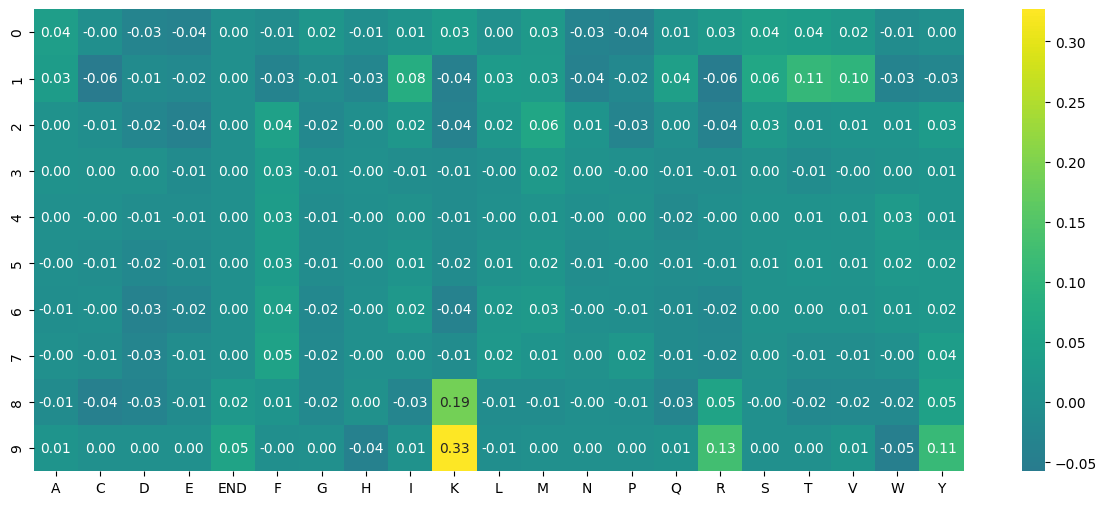

In [7]:
pd.DataFrame(poshap_a1101)

plt.figure(figsize=(15, 6))
ax = sns.heatmap(poshap_a1101, cmap='viridis', center=0, annot=True, fmt= '.2f',)

current_labels = [item.get_text() for item in ax.get_xticklabels()]
new_labels = [list(input_dict.keys())[int(label)] for label in current_labels]
ax.set_xticklabels(new_labels)

plt.show()

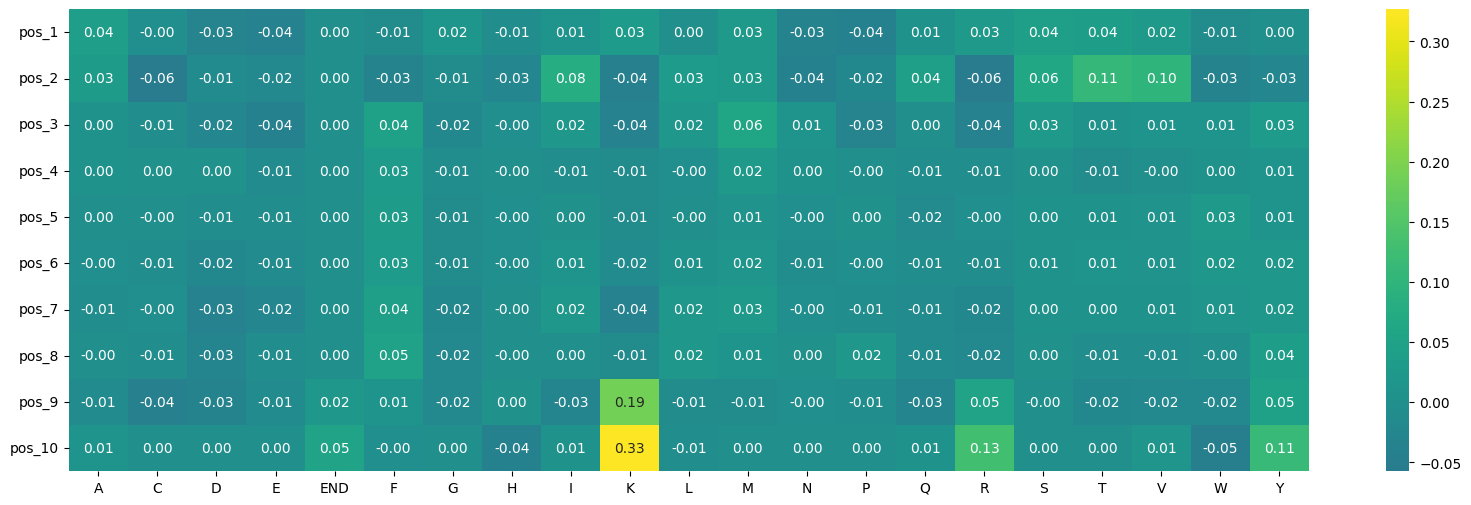

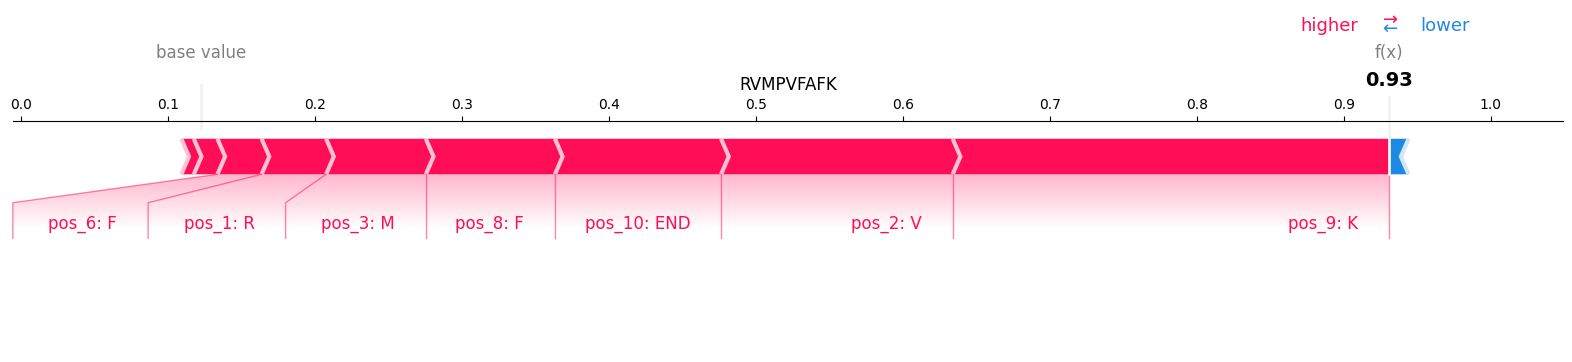

In [19]:
plt.figure(figsize=(20, 6))

# Heatmap
ax = sns.heatmap(poshap_a1101, cmap='viridis', center=0, annot=True, fmt= '.2f',)
current_labels = [item.get_text() for item in ax.get_xticklabels()]
new_labels = [list(input_dict.keys())[int(label)] for label in current_labels]
ax.set_xticklabels(new_labels)
ax.set_yticklabels(['pos_' + str(i+1) for i in range(10)])
ax.yaxis.set_tick_params(rotation=0)

# Top predicted force_plot
top_y_pred_index = np.argmax(y_pred)
input_seq = [list(input_dict.keys())[int(key)] for key in x_test.iloc[top_y_pred_index].values]
feature_names_with_values = [
    f'pos_{i+1}: {input_seq[i]}' for i in range(len(input_seq))
]
shap.force_plot(
    base_value=explainer.expected_value[0],
    shap_values=shap_values[top_y_pred_index][:, 0],
    features=input_seq,
    feature_names=feature_names_with_values,
    show=False,
    matplotlib=True
)
ax2 = plt.gca()
ax2.set_title(''.join([value if value != "END" else "" for value in input_seq]))

plt.show()

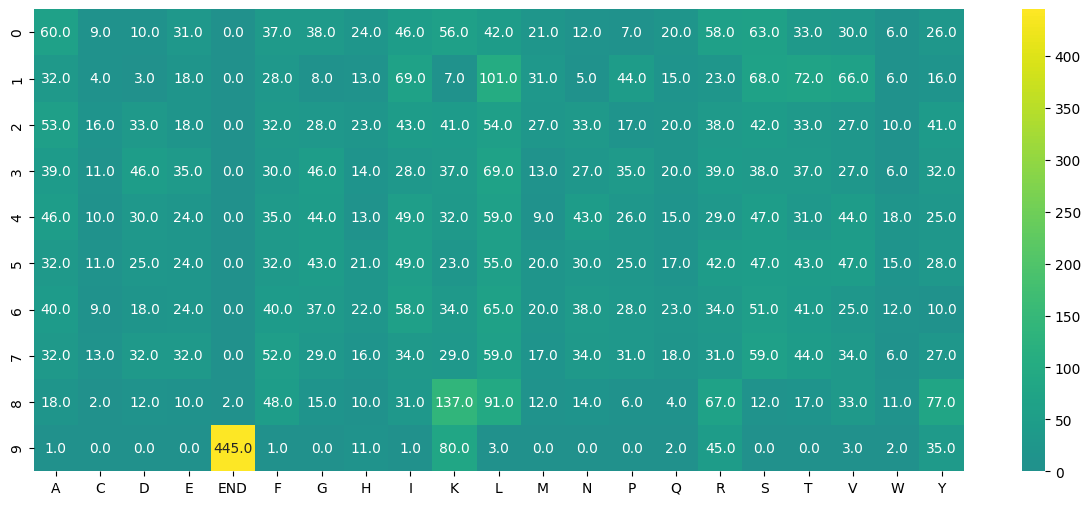

In [33]:
pd.DataFrame(count_a1101)

plt.figure(figsize=(15, 6))
ax = sns.heatmap(count_a1101, cmap='viridis', center=0, annot=True, fmt= '.1f')

current_labels = [item.get_text() for item in ax.get_xticklabels()]
new_labels = [list(input_dict.keys())[int(label)] for label in current_labels]
ax.set_xticklabels(new_labels)

plt.show()

<Figure size 2000x600 with 0 Axes>

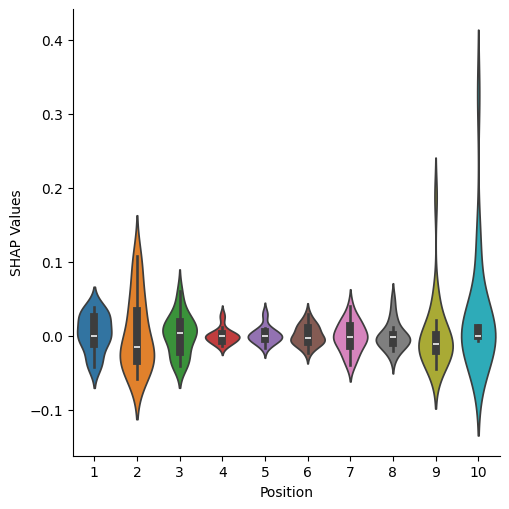

In [15]:
plt.figure(figsize=(20,6))
ax = sns.catplot(data=poshap_a1101, kind='violin')
ax.set_xlabels('Position')
ax.set_ylabels('SHAP Values')
ax.set_xticklabels([str(i+1) for i in range(10)])

plt.savefig('Images/6_A1101_catplot.png')
plt.show()

<Figure size 2000x600 with 0 Axes>

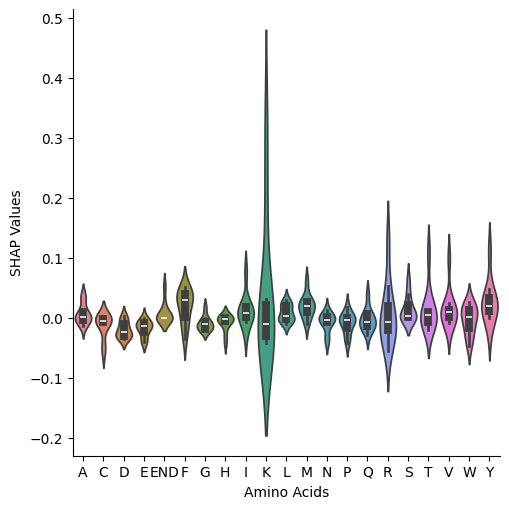

In [16]:
plt.figure(figsize=(20,6))
ax = sns.catplot(data=np.array(poshap_a1101), kind='violin')
ax.set_xlabels('Amino Acids')
ax.set_ylabels('SHAP Values')
ax.set_xticklabels([list(input_dict.keys())[int(key)] for key in range(21)])

plt.savefig('Images/7_A1101_AA_catplot.png')
plt.show()

# Linear Regression to get Top values

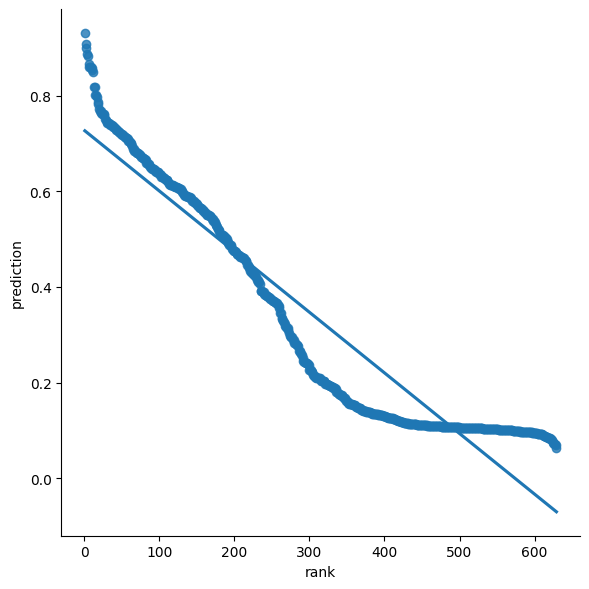

In [59]:
# Rank the output prediction and plot linear regression

y_pred_for_reg = y_pred.copy()
y_pred_for_reg = y_pred_for_reg.rename(columns={0: 'prediction'})
y_pred_for_reg['rank'] = y_pred_for_reg['prediction'].rank(ascending=False)

sns.lmplot(x='rank', y='prediction', data=y_pred_for_reg, fit_reg=True, height=6, ci=None)
plt.savefig('Images/8_A1101_Linear_top_predicted.png')

In [31]:
y_pred_sorted = y_pred_for_reg.sort_values(by='rank')

prediction    0.865849
rank          6.000000
Name: 115, dtype: float64

In [50]:
# Extract to top value

import statsmodels.api as sm

X = sm.add_constant(y_pred_for_reg['rank'])
y = y_pred_for_reg['prediction']

model = sm.OLS(y, X).fit()

intercept, slope = model.params
top_y_pred = pd.DataFrame()

y_pred_sorted = y_pred_for_reg.sort_values(by='rank')
for i, index in enumerate(y_pred_sorted['rank'].index):
    if (i*slope + intercept) <= y_pred_sorted['prediction'][index]:
        top_y_pred = pd.concat([top_y_pred, y_pred_sorted.loc[index:index]])
    else:
        break

In [53]:
top_shap_values = shap_values[top_y_pred.index]
top_poshap = [[[0.0, 0] for _ in range(21)] for _ in range(10)]
for i in range(top_shap_values.shape[0]):
    pos_index = 0
    for value in top_shap_values[i, :, 0]:
        input_array = [list(input_dict.keys())[int(key)] for key in x_test.iloc[i]]
        top_poshap[pos_index][input_dict.get(input_array[pos_index])][0] += value
        top_poshap[pos_index][input_dict.get(input_array[pos_index])][1] += 1
        pos_index += 1

top_poshap_a1101 = [[value[0]/(value[1] if value[1] != 0 else 1) for value in top_poshap[i]] for i in range(10)]
top_count_a1101 = [[value[1] for value in top_poshap[i]] for i in range(10)]

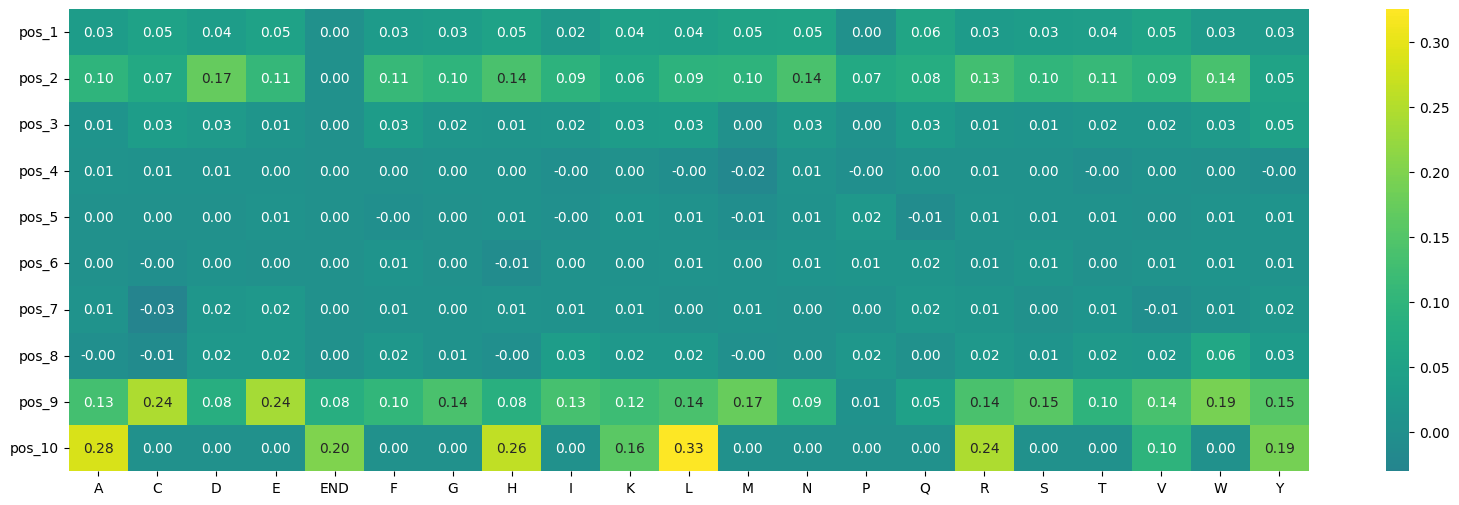

In [57]:
# Show heatmap of top predicted value
plt.figure(figsize=(20, 6))

ax = sns.heatmap(top_poshap_a1101, cmap='viridis', center=0, annot=True, fmt= '.2f',)
current_labels = [item.get_text() for item in ax.get_xticklabels()]
new_labels = [list(input_dict.keys())[int(label)] for label in current_labels]
ax.set_xticklabels(new_labels)
ax.set_yticklabels(['pos_' + str(i+1) for i in range(10)])
ax.yaxis.set_tick_params(rotation=0)

plt.savefig('Images/8_A1101_Linear_top_predicted_poshap.png')
plt.show()

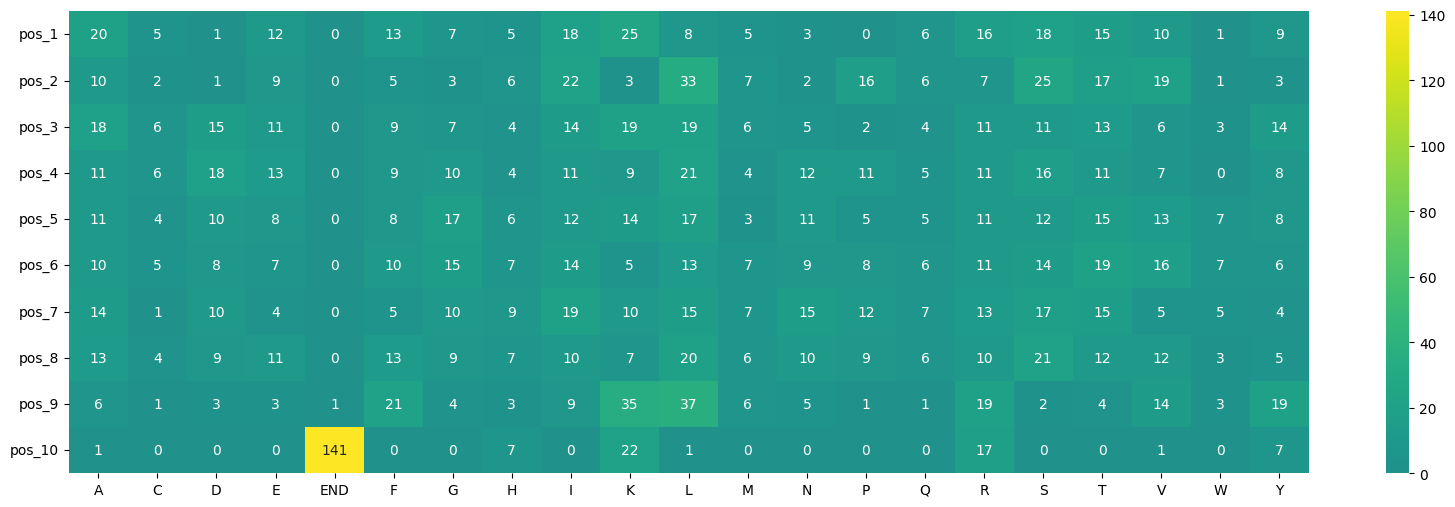

In [60]:
# Show heatmap of top predicted value
plt.figure(figsize=(20, 6))

ax = sns.heatmap(top_count_a1101, cmap='viridis', center=0, annot=True, fmt= 'd',)
current_labels = [item.get_text() for item in ax.get_xticklabels()]
new_labels = [list(input_dict.keys())[int(label)] for label in current_labels]
ax.set_xticklabels(new_labels)
ax.set_yticklabels(['pos_' + str(i+1) for i in range(10)])
ax.yaxis.set_tick_params(rotation=0)

plt.savefig('Images/8_A1101_Linear_top_predicted_count.png')
plt.show()

In [14]:
shap_values = np.load('Reg_SHAP/A1101_shap_values.npy')

In [8]:
# Dependency analysis


# Divide 2 group

first_aa = [[[[[] for _ in range(10)] for _ in range(21)] for _ in range(21)] for _ in range(10)]
compare_aa = [[[[[] for _ in range(10)] for _ in range(21)] for _ in range(21)] for _ in range(10)]

for f_pos in range(10):
    for f_aa in range(21):
        if f_aa != placeholder_index:   
            for c_pos in range(10):
                if f_pos != c_pos:
                    for c_aa in range(21):
                        if c_aa != placeholder_index:
                            for i in range(x_test.shape[0]):
                                if x_test.iloc[i, f_pos] == f_aa and x_test.iloc[i, c_pos] == c_aa:
                                    first_aa[f_pos][f_aa][c_aa][c_pos].append(shap_values[i, f_pos, 0])
                                if x_test.iloc[i, f_pos] == f_aa and x_test.iloc[i, c_pos] != c_aa:
                                    compare_aa[f_pos][f_aa][c_aa][c_pos].append(shap_values[i, f_pos, 0])
                        

In [15]:
np.save('Dep/A1101_firstdep.npy', pd.DataFrame(first_aa).to_numpy())
np.save('Dep/A1101_comdep.npy', pd.DataFrame(compare_aa).to_numpy())

NameError: name 'first_aa' is not defined

In [17]:
first_aa = np.load('Dep/A1101_firstdep.npy', allow_pickle=True)
compare_aa = np.load('Dep/A1101_comdep.npy', allow_pickle=True)

In [20]:
from scipy.stats import mannwhitneyu

output = []

for f_pos in range(len(first_aa)):
    for f_aa in range(len(first_aa[f_pos])):
        for c_aa in range(len(first_aa[f_pos][f_aa])):
            for c_pos in range(len(first_aa[f_pos][f_aa][c_aa])):
                try:
                    stat, test = mannwhitneyu(first_aa[f_pos][f_aa][c_aa][c_pos], compare_aa[f_pos][f_aa][c_aa][c_pos])
                except ValueError:
                    stat = 1
                    test = 1
                if test < 1 and test > 0:
                    output.append([test, list(input_dict.keys())[f_aa], f_pos + 1, c_pos + 1, list(input_dict.keys())[c_aa], len(first_aa[f_pos][f_aa][c_aa][c_pos]), len(compare_aa[f_pos][f_aa][c_aa][c_pos])])


/tmp/ipykernel_246288/119172041.py:10: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  stat, test = mannwhitneyu(first_aa[f_pos][f_aa][c_aa][c_pos], compare_aa[f_pos][f_aa][c_aa][c_pos])


In [21]:
output = pd.DataFrame(output, columns=['p-val', 'aa', 'pos', 'compare aa', 'compare pos', 'compare size', 'total size'])

In [22]:
from statsmodels.stats import multitest
corr_pval = multitest.multipletests(output['p-val'].tolist(), alpha=0.05, method='bonferroni', is_sorted=False, returnsorted=False)
output.insert(1, 'corr p-val', corr_pval[1])
output

,p-val,corr p-val,aa,pos,compare aa,compare pos,compare size,total size
0,0.663745,1.0,A,1,2,A,9,51
1,0.277206,1.0,A,1,3,A,3,57
2,0.748919,1.0,A,1,4,A,3,57
3,0.950478,1.0,A,1,5,A,9,51
4,0.364838,1.0,A,1,6,A,7,53
...,...,...,...,...,...,...,...,...
18629,0.914286,1.0,Y,10,1,Y,2,33
18630,0.012529,1.0,Y,10,3,Y,3,32
18631,0.082391,1.0,Y,10,4,Y,4,31
18632,0.971429,1.0,Y,10,5,Y,2,33


In [24]:
output_below = output.loc[output['corr p-val'] <= 0.05]
output_below.sort_values(by='corr p-val', ascending=True)
output_below.to_csv('a1101_de.csv')

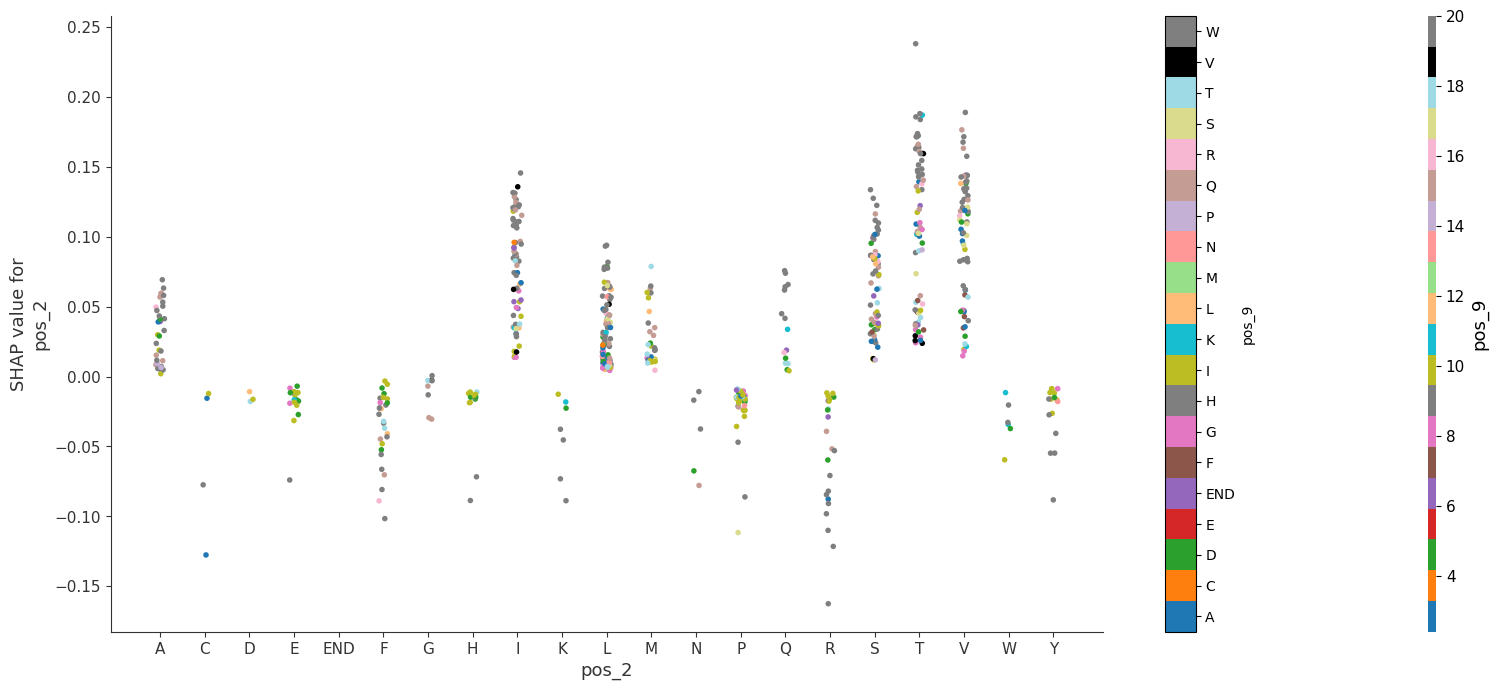

In [31]:
import matplotlib.cm as cm
import numpy as np
import matplotlib.colors as mcolors

base = 1
interactions = 8

colors =  [
    "#1f77b4",  # Blue
    "#ff7f0e",  # Orange
    "#2ca02c",  # Green
    "#d62728",  # Red
    "#9467bd",  # Purple
    "#8c564b",  # Brown
    "#e377c2",  # Pink
    "#7f7f7f",  # Gray
    "#bcbd22",  # Olive
    "#17becf",  # Cyan
    "#ffbb78",  # Light Orange
    "#98df8a",  # Light Green
    "#ff9896",  # Light Red
    "#c5b0d5",  # Light Purple
    "#c49c94",  # Light Brown
    "#f7b6d2",  # Light Pink
    "#dbdb8d",  # Light Olive
    "#9edae5",  # Light Cyan
    "#000000",  # Black
    "#7f7f7f",  # Dark Gray
    "#ffddc1"   # Very Light Orange
]
# colors.reverse()
custom_cmap = mcolors.ListedColormap(colors[:y_max])

fig, ax = plt.subplots(figsize=(20, 8))
shap.dependence_plot(base, shap_values[:, : , 0], x_test.iloc[:,:], interaction_index=interactions, ax = ax, x_jitter=0.2, show=False, cmap=custom_cmap, feature_names=['pos_' + str(i + 1) for i in range(10)])
ax.set_xticks(range(len(input_dict.keys())))
ax.set_xticklabels(list(input_dict.keys()))

cbar = ax.figure.axes[1]
y_max = round(cbar.get_ylim()[1])
# cbar.set_yticks(range(0, len(input_dict.keys()) - 2))
# cbar.ticklabel_format(axis='y', useOffset=False)
# cbar.set_yticklabels(list(input_dict.keys()))
# cbar.set_ylim(0.5, (len(input_dict.keys()) + 0.5))
# cbar.clear()
# cbar.set_axis_off()

norm = mcolors.BoundaryNorm(boundaries=np.arange(y_max + 1) - 0.5, ncolors=y_max)
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=custom_cmap), ax=ax, orientation='vertical')
cbar.set_ticks(range(y_max))
cbar.set_ticklabels(list(input_dict.keys())[:y_max])
cbar.minorticks_off()
cbar.set_label('pos_' + str(interactions + 1))

plt.show()